In [5]:
import pandas as pd
import mysql.connector

!pip install mysql-connector-python



Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Project Objective :

The objective of this project is to analyze user behavior across the
conversion funnel — from registration to content engagement and final purchase.

The analysis focuses on:
- Time taken by users to watch their first content after registration
- Time taken by engaged users to convert into paying customers
- Identifying drop-off points in the funnel


# Data Source & SQL Logic

The data was generated and stored in a MySQL database using the following tables:
- student_info (registration data)
- student_engagement (content watch activity)
- student_purchases (purchase data)

SQL joins were used to combine these tables:
- INNER JOIN to connect registrations with engagement
- LEFT JOIN to retain users who never made a purchase

MIN(date) was used to capture first engagement and first purchase dates.


# Key Insights

- Out of all engaged users, only 40% converted into paying customers.
- Most users engage with content shortly after registration.
- The time taken to convert after engagement is more spread out,
  indicating hesitation or decision delay before purchase.


# Business Recommendations

- Introduce onboarding nudges within the first week to reduce engagement delay.
- Trigger reminder emails or in-app offers for users who watched content
  but did not purchase within 10 days.
- Segment users based on conversion delay and apply targeted remarketing.


In [1]:
# import mysql.connector

# try:
#     conn = mysql.connector.connect(
#         host="localhost",
#         user="root",
#         password="*****",
#         database="db_course_conversions"
#     )
#
#     if conn.is_connected():
#         print("Connection successful!")
#
# except mysql.connector.Error as err:
#     print(f"Error: {err}")

print("Database connection code removed for security reasons.")



Connection successful!


In [11]:

query = """
SELECT
    e.student_id,
    i.date_registered,
    MIN(e.date_watched) AS first_date_watched,
    MIN(p.date_purchased) AS first_date_purchased,
    DATEDIFF(MIN(e.date_watched), i.date_registered) AS diff_reg_watch,
    DATEDIFF(MIN(p.date_purchased), MIN(e.date_watched)) AS diff_watch_purch
FROM student_engagement e
JOIN student_info i
    ON e.student_id = i.student_id
LEFT JOIN student_purchases p
    ON e.student_id = p.student_id
GROUP BY e.student_id, i.date_registered
HAVING first_date_purchased IS NULL
    OR first_date_watched <= first_date_purchased
"""
df = pd.read_sql(query, conn)

C:\Users\HP\AppData\Local\Temp\ipykernel_14776\280955764.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [35]:
print(df.shape)
print(df.columns)
df


(250, 6)
Index(['student_id', 'date_registered', 'first_date_watched',
       'first_date_purchased', 'diff_reg_watch', 'diff_watch_purch'],
      dtype='object')


,student_id,date_registered,first_date_watched,first_date_purchased,diff_reg_watch,diff_watch_purch
0,1,2023-06-11,2023-06-28,None,17,NaN
1,2,2023-01-22,2023-02-20,None,29,NaN
2,3,2022-12-21,2022-12-27,2023-01-09,6,13.0
3,5,2023-06-20,2023-06-20,None,0,NaN
4,6,2022-04-21,2022-05-06,2022-05-23,15,17.0
...,...,...,...,...,...,...
245,252,2023-12-01,2024-01-23,2024-02-08,53,16.0
246,264,2023-03-17,2023-05-09,2023-05-15,53,6.0
247,276,2022-03-03,2022-04-16,2022-04-17,44,1.0
248,288,2023-01-18,2023-01-28,2023-02-04,10,7.0


In [15]:
total_users = len(df)
purchased_users = df['first_date_purchased'].notna().sum()
conversion_rate = round((purchased_users / total_users) * 100, 2)

print("Total Users:", total_users)
print("Purchased Users:", purchased_users)
print("Conversion Rate (%):", conversion_rate)


Total Users: 250
Purchased Users: 100
Conversion Rate (%): 40.0


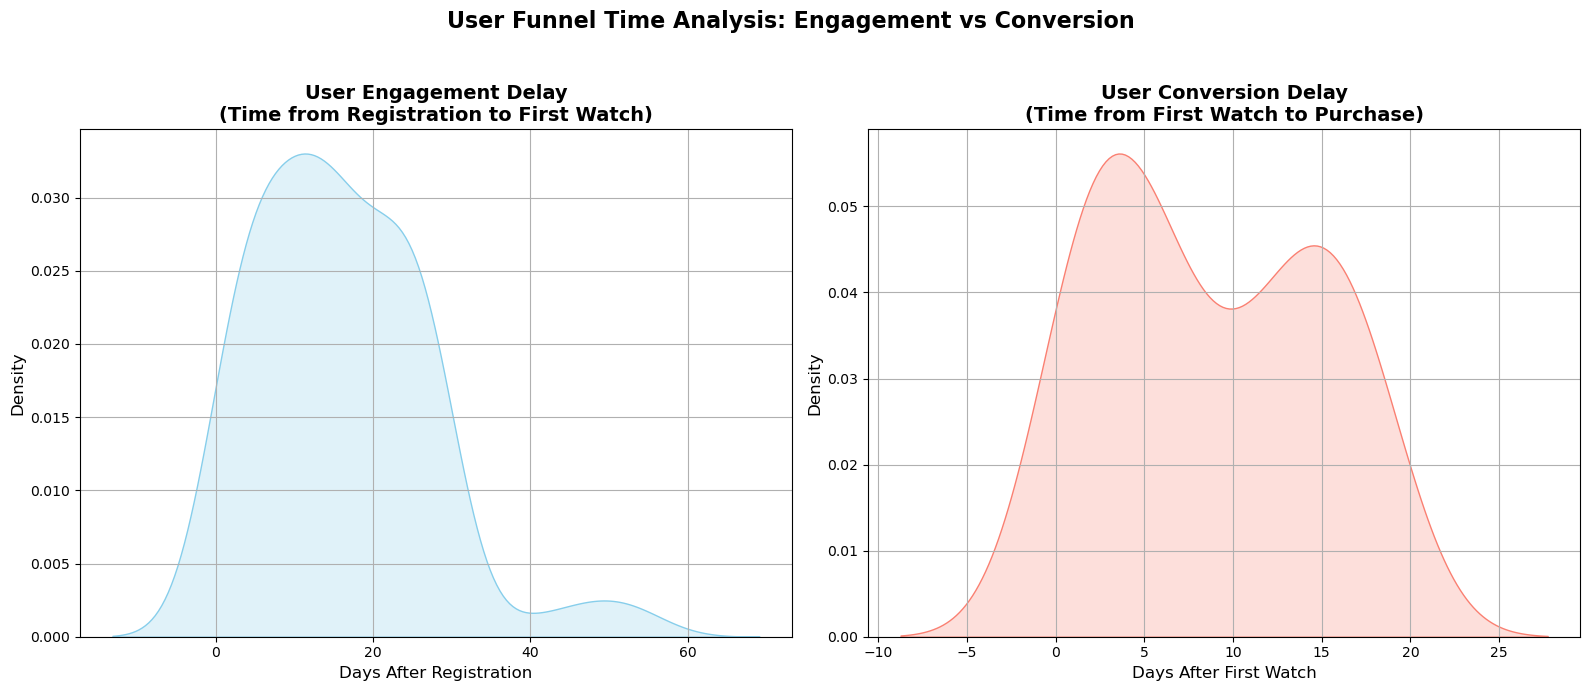

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 7))

#  Registration → Watch
plt.subplot(1, 2, 1)
sns.kdeplot(df['diff_reg_watch'].dropna(), fill=True, color='skyblue', bw_adjust=1.2)
plt.xlabel("Days After Registration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("User Engagement Delay\n(Time from Registration to First Watch)", fontsize=14, fontweight='bold')
plt.grid(True)

#  Watch → Purchase
plt.subplot(1, 2, 2)
sns.kdeplot(df['diff_watch_purch'].dropna(), fill=True, color='salmon', bw_adjust=1.2)
plt.xlabel("Days After First Watch", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("User Conversion Delay\n(Time from First Watch to Purchase)", fontsize=14, fontweight='bold')
plt.grid(True)

plt.suptitle("User Funnel Time Analysis: Engagement vs Conversion ", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
